# Salt stress downregulates AhrC

In [2]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)
from ecolime.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(ecolime.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/ecolime/__init__.py


Load

In [3]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()
base_mu = bsub.solution.f

In [4]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)
ions = ['na1_e','ca2_e','zn2_e','k_e']

## RNASeq data

In [5]:
data = pd.read_csv('rna_seq/RNAseq_raw.csv',index_col=1)

RNAseq data appears to be normalized. That means that roughly they have the same numbre of cells.

In [6]:
stress_data.sum(axis=0)

NameError: name 'stress_data' is not defined

In [ ]:
samples = data.columns
control_data = data[samples[samples.str.contains('SMM_')]]
stress_data = data[samples[samples.str.contains('Salt')]]
fold_change = np.divide(stress_data,control_data)

### Arginine biosynthesis

In [ ]:
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF', 'carA', 'carB']
fold_change.loc[gene_dictionary.loc[genes]['locus_id']].mean(axis=1).to_frame().boxplot()
plt.ylabel('fold_change')
plt.title('Arginine biosynthetic gene expression ')

Arginine biosynthesis is downregulated in salt stress.

### Transporter expression

In [ ]:
# Identify uptake and secretion transporters
uptake_rxns = get_transport_reactions(bsub,'na1_e',verbose=0)
transporter_ids=[]
for rxn in uptake_rxns:
    genes_uptake = rxn.genes
    transporters = [gene.id for gene in genes_uptake]
    for t in transporters:
        transporter_ids.append(t)
        
secretion_rxns = get_transport_reactions(bsub,'na1_e',verbose=0,comps=['c','e'])
secretor_ids=[]
for rxn in secretion_rxns:
    genes_secretion = rxn.genes
    transporters = [gene.id for gene in genes_secretion]
    for t in transporters:
        secretor_ids.append(t)

In [ ]:

plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
fold_change.loc[transporter_ids].mean(axis=1).to_frame().boxplot()
plt.title('Uptake')
plt.ylabel('Fold change')

plt.subplot(1,2,2)
fold_change.loc[secretor_ids].mean(axis=1).to_frame().boxplot()
plt.title('Secretion')
plt.ylabel('Fold change')

plt.tight_layout()

Downregulation of uptake transporters means that either the same or a reduced amount of uptake transporters should be expressed in salt stress. That means that to properly model this in the ME-model it is necessary to add transport reactions that do not induce expression of transporters.

## M-model simulations

In [ ]:
bsub = cobra.io.load_json_model(ijo_directory)
na1_e = bsub.metabolites.na1_e
## Separate sodium entrance and exit
bsub.reactions.EX_na1_e.lower_bound = 0
bsub.reactions.EX_na1_e.upper_bound = 0

# Create sodium metabolites
na1_in = cobra.Metabolite(id='na1_in')
na1_out = cobra.Metabolite(id='na1_out')
bsub.add_metabolites([na1_in,na1_out])

# Sodium uptake
rxn = cobra.Reaction(id='EX_na1_in')
rxn.add_metabolites({
    na1_in:-1.0
})
rxn.lower_bound = -1000
rxn.upper_bound = 0
bsub.add_reaction(rxn)
print(rxn.reaction)
# Sodium exit
rxn = cobra.Reaction(id='DM_na1_out')
rxn.add_metabolites({
    na1_out:-1.0
})
rxn.lower_bound = 0
rxn.upper_bound = 1000
bsub.add_reaction(rxn)
print(rxn.reaction)

In [ ]:
uptake_rxns = get_reactions_of_met(bsub,'na1_e',s = -1,verbose=0)
exit_rxns = get_reactions_of_met(bsub,'na1_e',s = 1,verbose=0)

for rxn in uptake_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_in:coeff})
    print(rxn.reaction)
for rxn in exit_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_out:coeff})
    print(rxn.reaction)

In [ ]:
# Sodium rates and simulation
na_rates = -np.arange(0,5,0.1)*1e-3
flux_dict = dict()
for rate in na_rates:
    bsub.reactions.get_by_id('EX_na1_in').lower_bound = rate
    bsub.reactions.get_by_id('EX_na1_in').upper_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

In [ ]:
fig,ax1 = plt.subplots()
plt.title('Sodium uptake')

ax1.plot(-flux_responses.loc['EX_na1_in'],flux_responses.loc['BIOMASS_BS_10'],
            label = 'growth',color='tab:red')
ax1.set_xlabel('Sodium uptake')
ax1.set_ylabel('Growth rate')

ax2 = ax1.twinx()
ax2.plot(-flux_responses.loc['EX_na1_in'],flux_responses.loc['EX_o2_e'],
            label = 'Glucose')
ax2.plot(-flux_responses.loc['EX_na1_in'],flux_responses.loc['EX_glc__D_e'],
            label = 'O2')
ax2.set_ylabel('Rate')

ax2.legend()

M-model predicts an increase in growth rate at increased sodium uptake

In [ ]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)

In [ ]:
flux_responses = pd.DataFrame.from_dict(flux_dict)

In [ ]:
import pandas as pd
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF', 'carA', 'carB']
for idx,gene in enumerate(gene_dictionary.loc[genes]['locus_id'].values):
    rxns = bsub.genes.get_by_id(gene).reactions
    for rxn in rxns:
        flux_profile = abs(flux_responses.loc[rxn.id].values)
        flux_profile /= max(flux_profile)
        plt.plot(na_rates,flux_profile,label=genes[idx]+'_'+rxn.id)
plt.title('Response to salt stress')
plt.xlabel('Sodium uptake')
plt.ylabel('Flux')
plt.legend()

Is it an artifact of growth rate increase?

In [ ]:
bsub.reactions.get_by_id('EX_glc__D_e').lower_bound = -10
bsub.reactions.get_by_id('BIOMASS_BS_10').lower_bound = base_mu
bsub.reactions.get_by_id('BIOMASS_BS_10').upper_bound = base_mu

bsub.objective = 'EX_glc__D_e'
bsub.reactions.get_by_id('EX_glc__D_e').objective_coefficient = -1.

# Sodium rates and simulation
na_rates = -np.arange(0,5,0.1)*1e-3
flux_dict = dict()
for rate in na_rates:
    bsub.reactions.get_by_id('EX_na1_in').lower_bound = rate
    bsub.reactions.get_by_id('EX_na1_in').upper_bound = rate
    solution = bsub.optimize()
    flux_dict[rate] = solution.x_dict
flux_responses = pd.DataFrame.from_dict(flux_dict)

In [ ]:
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF', 'carA', 'carB']
for idx,gene in enumerate(gene_dictionary.loc[genes]['locus_id'].values):
    rxns = bsub.genes.get_by_id(gene).reactions
    for rxn in rxns:
        flux_profile = abs(flux_responses.loc[rxn.id].values)
        flux_profile /= max(flux_profile)
        plt.plot(na_rates,flux_profile,label=genes[idx]+'_'+rxn.id)
plt.title('Response to salt stress')
plt.xlabel('Sodium uptake')
plt.ylabel('Flux')
plt.legend()

M-model is not able to capture the decrease in AhrC regulon

## ME-model simulations

In [ ]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [ ]:
#new_mu = me.solution.f
new_mu = False

Add those reactions that account for osmosis

In [ ]:
# Add a copy of transport reactions that do not need a transporter
uptake_rxns = get_transport_reactions(me,'na1_e',comps=['e','c'],verbose=0)
osm_rxns = []
for rxn in uptake_rxns:
    stoich = rxn.stoichiometric_data.stoichiometry
    osm_id = rxn.id.split('_FWD')[0]+'_osm'
    
    if not hasattr(me.reactions,osm_id):
        osm_rxn = cobrame.MEReaction(osm_id)
        me.add_reaction(osm_rxn)

        osm_rxn.add_metabolites(stoich)
        osm_rxn.lower_bound=0
        osm_rxn.upper_bound=1000
        osm_rxns.append(osm_rxn)
        print(osm_rxn.id,osm_rxn.lower_bound,osm_rxn.upper_bound,osm_rxn.reaction)   


Add sodium uptake and exit separately

In [ ]:
from cobrame import MEReaction,Metabolite

na1_e = me.metabolites.na1_e
## Separate sodium entrance and exit
me.reactions.EX_na1_e.lower_bound = 0
me.reactions.EX_na1_e.upper_bound = 0

# Create sodium metabolites
na1_in = Metabolite(id='na1_in')
na1_out = Metabolite(id='na1_out')
me.add_metabolites([na1_in,na1_out])

# Sodium uptake
rxn = MEReaction(id='EX_na1_in')
rxn.add_metabolites({
    na1_in:-1.0
})
rxn.lower_bound = -1000
rxn.upper_bound = 0
me.add_reaction(rxn)
print(rxn.id,rxn.reaction)
# Sodium exit
rxn = MEReaction(id='DM_na1_out')
rxn.add_metabolites({
    na1_out:-1.0
})
rxn.lower_bound = 0
rxn.upper_bound = 1000
me.add_reaction(rxn)
print(rxn.id,rxn.reaction)

In [ ]:
uptake_rxns = get_transport_reactions(me,'na1_e',comps=['e','c'],verbose=0)
exit_rxns = get_transport_reactions(me,'na1_e',comps=['c','e'],verbose=0)
for rxn in uptake_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_in:coeff})
    print(rxn.id,rxn.reaction)
print('\n')
for rxn in exit_rxns:
    coeff = rxn.pop(na1_e)
    rxn.add_metabolites({na1_out:coeff})
    print(rxn.id,rxn.reaction)

### Calculations

In [ ]:
def single_flux_response(me,rate,mu_fix=False):
    me.reactions.get_by_id('EX_na1_in').lower_bound = rate
    me.reactions.get_by_id('EX_na1_in').upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [ ]:
# Calculation at several sodium uptake rates
na_rates=-np.arange(0,5,0.5)*1e-2
flux_dict = dict()
print('Rates to use: {}'.format(na_rates))

import multiprocessing as mp
NP = min([len(na_rates),10])
pool = mp.Pool(NP)
pbar = tqdm(total=len(na_rates))
pbar.set_description('Sodium stress ({} threads)'.format(NP))
def collect_result(result):
    pbar.update(1)
    flux_dict[result[0]] = result[1]
for rate in na_rates:
    pool.apply_async(single_flux_response, args=(me,rate,new_mu), callback=collect_result)
pool.close()
pool.join()
flux_responses_me = pd.DataFrame.from_dict(flux_dict)
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
flux_responses_me.head()

In [ ]:
# Save results
flux_responses_me.to_csv('salt_flux_responses.csv',index_label='rxn_id')

In [ ]:
flux_responses_me = pd.read_csv('salt_flux_responses.csv',index_col=0)

In [ ]:
# Visualize transcription profiles
plt.figure(figsize=(10,4))

# TU8J2-912 operon: argCJBDF-carAB
plt.subplot(1,2,1)
expression = flux_responses_me.loc['transcription_TU8J2_912_from_BSU25200-MONOMER']
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         expression/max(expression),
         marker = 'o',markersize=8)
plt.title('Transcription of arg operon (TU8J2-912)')
plt.ylabel('Transcription level')
plt.xlabel('Sodium uptake')

# argHG transcription
plt.subplot(1,2,2)
expression = flux_responses_me.loc['transcription_TU_BSU29450']
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         expression/max(expression), label='argG',
         marker = 'o',markersize=8)
expression = flux_responses_me.loc['transcription_TU_BSU29440']
plt.plot(-flux_responses_me.loc['EX_na1_in'],
         expression/max(expression), label='argH',
         marker = 'o',markersize=8)
plt.legend()
plt.title('Transcription of argHG operon')
plt.ylabel('Transcription level')
plt.xlabel('Sodium uptake')


Text(0.5, 1.0, 'artPQR')

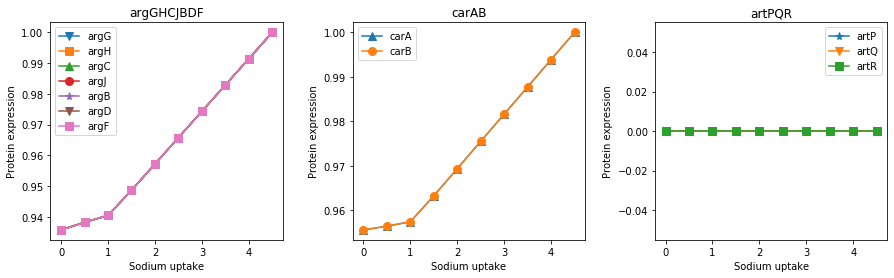

In [91]:
# Visualize protein expression profiles
plt.figure(figsize=(15,4))
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

flux_responses_me[abs(flux_responses_me)<1e-16] = 0

plt.subplots_adjust(wspace=0.3)
plt.subplot(1,3,1)
genes = ['argG', 'argH', 'argC', 'argJ', 'argB', 'argD', 'argF']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_na1_in'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('argGHCJBDF')

plt.subplot(1,3,2)
genes = ['carA', 'carB']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_na1_in'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('carAB')

plt.subplot(1,3,3)
genes = ['artP', 'artQ','artR']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    plt.plot(-flux_responses_me.loc['EX_na1_in'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('artPQR')

# artPQR are not included in the model

Notes:
* Sodium was forced to go through the model by creating na1_in and na1_out. Otherwise, it would have exited the model without going through the network from EX to DM